In [75]:
import pandas as pd; import numpy as np;
import seaborn as sns;
import pystache, plotly, json, random, sys
import plotly.graph_objects as go

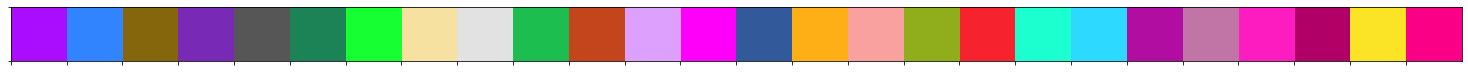

In [76]:
plotly.colors.qualitative
COLORS = plotly.colors.qualitative.Alphabet
sns.palplot(COLORS)

In [77]:
def normalize(values, desired_bounds):
    actual_bounds = (min(values), max(values))
    return [desired_bounds[0] + (x - actual_bounds[0]) *
            (desired_bounds[1] - desired_bounds[0]) / \
            (actual_bounds[1] - actual_bounds[0]) for x in values]


## Step 1: Read in DataFrame

In [78]:
def read_dataframe(file):
    sys.stderr.write("Loading "+file+"...")
    to_plot = json.load(open(file,'r')) #Could put error handling here if necessary
    
    df = pd.DataFrame(to_plot)
    df['timestamp'] = df.created_at.apply(lambda t: pd.Timestamp(t))
    sys.stderr.write(("Read {:,} retweets\n".format(len(to_plot))))
        
    # Precompute some things for plotting
    df['markerSizeLog'] = df.followers_count.apply(lambda f: int(np.log(f+1)))
        
    return df

## Step 2: Make Figure

In [79]:
def buildPlotlyHTML(df, topN=26):
    
    sys.stderr.write("Plotting top {}".format(topN-1))
    
    # To return
    fig = go.Figure()
    data_for_html = {}

    for topNidx in range(1,topN):
        
        #Should be sorted safely?
        plot_df = df[df.top_N==topNidx].sort_values(by='id')
        
        tweetId   = str(plot_df.head(1).id.values[0])
        tweetText = plot_df.head(1).text.values[0]
        
        if pd.isna(tweetText):
            raise "No Tweet Text on First Entry"
        
        color = COLORS[topNidx%len(COLORS)]
        
        data_for_html[tweetId] = {
            'text' : tweetText,
            'user' : plot_df.head(1).username.values[0],
            'rank' : topNidx,
            'color': color,
            'id'   : tweetId
        }
        
        fig.add_trace(go.Scattergl(
            name = tweetId,
            x    = plot_df.timestamp, 
            y    = plot_df.followers_count_cumsum,
            mode = 'markers+lines',
            marker = dict(
                size  = normalize(list(plot_df.followers_count), (10,35)),
                color = color,
                opacity = normalize(list(plot_df.followers_count),(0.5,1)),
                line=dict(
                    color='white',
                    width=0.4
                ),
            ),
            line=dict(
                color=color,
                width=0.75,
            ),
            hovertemplate ='<i>Date</i>: %{x}<br>',
    #         text = [build_custom_label(i) for i in plot_df.index],
            meta={'u':plot_df.username,
                  'f':plot_df.followers_count,
                  'i':plot_df.id.apply(lambda x: str(x))},
            showlegend = True
        ))
        sys.stderr.write(".")

    fig.update_layout(
        autosize=False,
        width=1200,
        height=800,
        yaxis_title="Total # Followers (Cumulative Sum)",
    #     font=dict(
    #         family="Courier New, monospace",
    #         size=18,
    #         color="#7f7f7f")
        )
    sys.stderr.write("Done\n")
    return (fig, data_for_html)

<br><br><br><br><br><br><hr><br><br><br><br><br><br>


## Step 3: Create Static Webpage

Using Mustache and the templates available from 
[project-epic/covid19-static-pages](//github.com/project-epic/covid19-static-pages), create standalone webpages that have all the groovy interaction we want with minimal data support (i.e. single files).

In [80]:
def buildSingleStaticPlotlyPage(CONFIG, fig, data_for_html):
    sys.stderr.write("Writing HTML... ")
    
    main_template = open(CONFIG['static_pages']+'/templates/main.html').read()

    opts = {
        "TITLE"    : CONFIG['TITLE'],
        "SUBHEADER": CONFIG['SUBHEADER'],
        
        "INJECTED_JAVASCRIPT" : "const DATA = "+json.dumps(data_for_html),
        "PLOTLY_1" : plotly.io.to_html(fig, full_html=False, include_plotlyjs='cdn'),

    }

    with open(CONFIG['output'],'w') as outFile:
        outFile.write(pystache.render(main_template, opts))
    sys.stderr.write(" view at: http://epic.tweetsonamap.com/covid19-static-pages/"+CONFIG['output']+"\n")
    
buildSingleStaticPlotlyPage(WHO_Top25, who_data[1], who_data[2])

Writing HTML...  view at: http://epic.tweetsonamap.com/covid19-static-pages/docs/who.html


In [81]:
def fullRun(config):
    df = read_dataframe(config['data'])
    fig, data_for_html = buildPlotlyHTML(df)
    buildSingleStaticPlotlyPage(config, fig, data_for_html)
    return (df, fig, data_for_html)

# Runtime:

In [82]:
WHO_Top25 = {
'static_pages' : './',

"TITLE"      : "Top 25 Retweets of @WHO",
"SUBHEADER"  : "Diffusion of the top 25 most retweeted tweets from the W.H.O.",

"data"   : '/home/jupyter/data/diffusion/who_top_25_retweeted_050520.json',
"output" : 'docs/who.html'
}
who_data = fullRun(WHO_Top25)

Loading /home/jupyter/data/diffusion/who_top_25_retweeted_050520.json...Read 44,065 retweets
Plotting top 25.........................Done
Writing HTML...  view at: http://epic.tweetsonamap.com/covid19-static-pages/docs/who.html


In [83]:
CDC = {
'static_pages' : './',

"TITLE"      : "Top 25 Retweets of Center for Diseace Control",
"SUBHEADER"  : "Diffusion of the top 25 most retweeted @CDCGov, @CDCEmergency, @CDCEspañol, @CDCGlobal, @CDC_ehealth tweets",

"data"   : '/home/jupyter/data/diffusion/cdc_userstreams_top_25_retweeted_050520.json',
"output" : 'docs/cdc.html'
}
cdc_data = fullRun(CDC)

Loading /home/jupyter/data/diffusion/cdc_userstreams_top_25_retweeted_050520.json...Read 47,816 retweets
Plotting top 25.........................Done
Writing HTML...  view at: http://epic.tweetsonamap.com/covid19-static-pages/docs/cdc.html


In [84]:
CDC_Keywords = {
'static_pages' : './',

"TITLE"      : "Top 25 Retweets mentioning @CDCGov or @CDCEmergency",
"SUBHEADER"  : "Diffusion of the top 25 most retweeted tweets with '@CDCGov' or '@CDCEmergency' since mid-March",

"data"   : '/home/jupyter/data/diffusion/cdc_top_25_retweeted_050520.json',    
"output" : 'docs/cdc-keyword.html'
}
cdc_keyword_data = fullRun(CDC_Keywords)

Loading /home/jupyter/data/diffusion/cdc_top_25_retweeted_050520.json...Read 47,370 retweets
Plotting top 25.........................Done
Writing HTML...  view at: http://epic.tweetsonamap.com/covid19-static-pages/docs/cdc-keyword.html


In [85]:
def buildSample():
    fig = go.Figure()
    values = [100000,2000000,500000,500000,50000,50000]
    print(pd.Series(values).cumsum())
    fig.add_trace(go.Scattergl(
        x    = [1,2,3,4,5,6],
        y    = pd.Series(values).cumsum(),
        mode = 'markers+lines',
        marker = dict(
            size  = normalize(list(values), (10,35)),
            color = 'red',
            opacity = normalize(values,(0.5,1)),
            line=dict(
                color='white',
                width=0.4
            ),
        ),
        line=dict(
            color='red',
            width=0.75,
        ),
    ))

    fig.update_layout(
    autosize=False,
    width=600,
    height=600,
    yaxis_title="Total # Followers (Cumulative Sum)",
    xaxis_title="Day",
    #     font=dict(
    #         family="Courier New, monospace",
    #         size=18,
    #         color="#7f7f7f")
    )

    fig.show()
buildSample()

0     100000
1    2100000
2    2600000
3    3100000
4    3150000
5    3200000
dtype: int64
